# Backtesting

This notebook generates plots for the backtesting. It requires that the script `run_backtesting.sh` has been run prior to execution.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

In [3]:
# configure logging
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
# This line can be used to modify logging as required later in the notebook
#logging.getLogger().setLevel(logging.INFO)

In [4]:
# set matplotlib params
#matplotlib.rcParams["figure.dpi"] = 200
#matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [5]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 2161248 samples


In [6]:
# inspect the loaded data
print(columns.keys())
print('---')
for k in columns.keys():
    print(k, columns[k][0:2])

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])
---
lineage ['B.1', 'B.1']
virus_name ['hCoV-19/Australia/NT12/2020', 'hCoV-19/Australia/NT13/2020']
accession_id ['EPI_ISL_426900', 'EPI_ISL_426901']
collection_date ['2020-03-25', '2020-03-25']
location ['Oceania / Australia / Northern Territory', 'Oceania / Australia / Northern Territory']
add_location ['', '']
day [115, 115]


## Load trained models

In [7]:
fits = torch.load("results/mutrans.backtesting.pt", map_location="cpu")

In [8]:
# print info on available models and what the keys are
if False:
    for key in fits:
        print(key)
    first_key = list(fits.keys())[0]
    fits[first_key].keys()

In [9]:
# Print the shape of the weekly strains in each fit
if False:
    for fit in fits.values():
        print(fit["weekly_strains_shape"])

Scale `coef` by 1/100 in all results.

In [10]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix="", verbose=True):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                if verbose:
                    print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}", verbose=verbose)
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits, verbose=False)

# Forecasting

In [11]:
import importlib
from pyrocov import mutrans_helpers

In [12]:
# customize logging
if False:
    logging.getLogger().setLevel(logging.ERROR)

## Day 542: Last available

In [13]:
if False:
    logging.getLogger().setLevel(logging.INFO)

Max days of model: 542


    16311 Generating output tensor
    16312 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


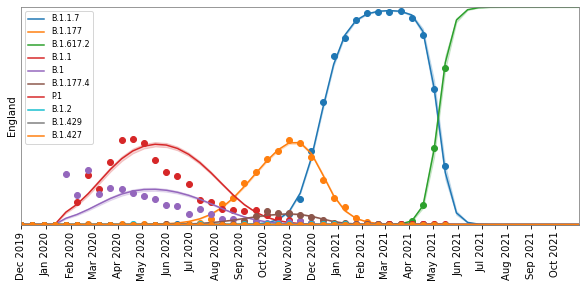

In [14]:
importlib.reload(mutrans_helpers)

i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']


matplotlib.rcParams['figure.figsize'] = [10, 4]
plot_return = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    filename="paper/forecasts/forecast_day_542.png"
)

# Day 514: B.1.617.2 in UK

Max days of model: 514


    25753 Generating output tensor
    25754 --- Processing query 0


sel_forecast shape torch.Size([49, 1281])
sel_forecast_lb shape torch.Size([49, 1281])


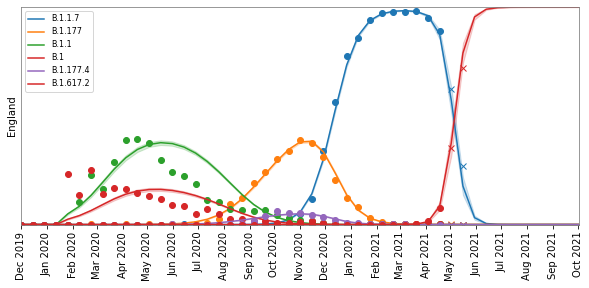

In [15]:
i = 26
key, fit_d514 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.177.4','B.1.1','B.1.177', 'B.1.617.2','B.1','B.1.1.7']

matplotlib.rcParams['figure.figsize'] = [10, 4]
england_day_514_plot_return = mutrans_helpers.plot_fit_forecasts(
    fit=fit_d514, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_514.png',
    forecast_periods_plot=2,
)

In [16]:
mutrans_helpers.evaluate_fit_forecast(fit_d514, latest_fit)

{'log_likelihood': tensor([-0.2402, -0.3840]),
 'entropy': tensor([0.6909, 0.6186]),
 'perplexity': tensor([2.2121, 2.0621]),
 'kl': tensor([nan, nan]),
 'mae': tensor([21.0482, 19.3891]),
 'rmse': tensor([5.7838, 3.4317, 1.5160,  ..., 0.0000, 0.0000, 4.6755]),
 'wasserstein': tensor([148.1149, 191.9854])}

In [17]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [18]:
x = np.linspace(0.0, 1.0, len(evaluations)+1)

In [19]:
cmap = matplotlib.cm.get_cmap('rainbow')

In [20]:
nValues = [k[8] for k,v in evaluations]
nValues = np.array(nValues)

In [21]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet

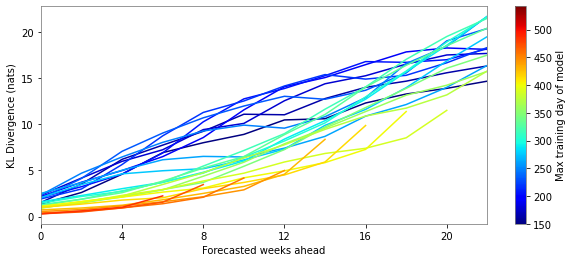

In [22]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    kl = v['kl']
    plt.plot(kl, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('KL Divergence (nats)')

plt.show()

In [23]:
# Alternative representation of KL divergence

start_days = []
forecast_days = []
kl = []

for i,(k,v) in enumerate(evaluations):
    start_days_c = k[8]
    kl_vals = v['kl']
    for j, p in enumerate(kl_vals):
        start_days.append(start_days_c)
        forecast_days.append(j)
        kl.append(p.numpy().item())

df1 = pd.DataFrame({"start":start_days,"forecast":forecast_days,"kl":kl}).pivot(index='start', columns='forecast')

<AxesSubplot:>

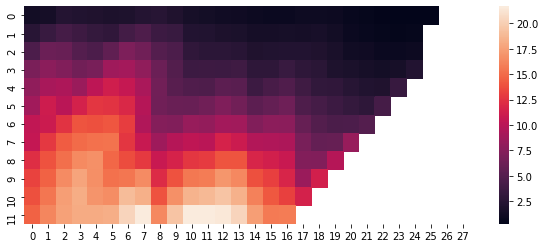

In [24]:
# generate heatmap
sns.heatmap(df1.T.to_numpy())

In [25]:
# MAE

In [26]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [27]:
# 

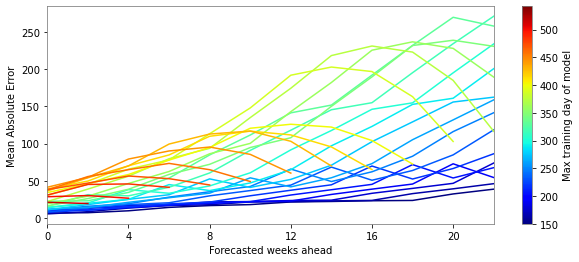

In [28]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['mae']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Mean Absolute Error')

plt.show()

In [29]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

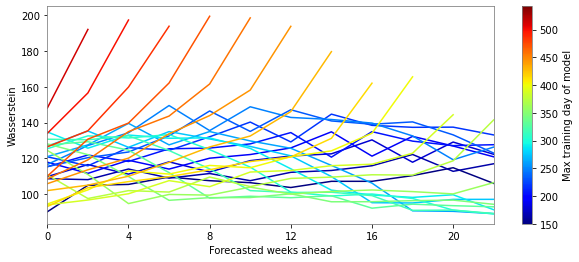

In [30]:
# Wasserstein distance

for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['wasserstein']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Wasserstein')

plt.show()

## Why is USA / California total sum going to zero at the end?

Max days of model: 542


   111526 Generating output tensor
   111527 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


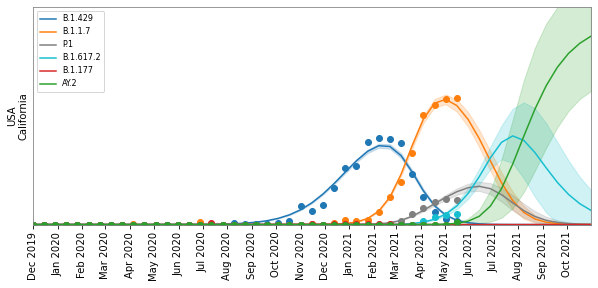

In [31]:
i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['AY.2','B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1']

matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['USA / California'],
)

## CA latest

In [32]:
def get_region_names(fit):
    return fit['location_id']

In [33]:
def find_prevalent_strains(fit, region, n=20):
    """Given a fit and region finds top n strains"""
    assert fit is not None
    assert region is not None
    
    fc0 = mutrans_helpers.generate_forecast(fit)
    
    region_index = fc0['location_id'][region]
    vals, indx = fit['mean']['probs'].max(0)
    so = vals[region_index,].sort(descending=True).indices[0:n].numpy()
    s0 = np.array(fit['lineage_id_inv'])[so].tolist()
    
    return s0
    

In [34]:
def find_prevalent_strains(fit, query, n=20):
    """Given a fit and region finds top n strains"""
    assert fit is not None
    assert query is not None
    
    fc0 = mutrans_helpers.generate_forecast(fit)
    
    
    location_id = fc0['location_id']
    
    
    ids = torch.tensor([i for name, i in location_id.items() if query in name])
    
    #region_index = fc0['location_id'][region]
    
    vals, indx = fit['mean']['probs'].index_select(-2, ids).sum(-2).max(0)
    
    #so = vals[region_index,].sort(descending=True).indices[0:n].numpy()
    so = vals.sort(descending=True).indices[0:n].numpy()
    s0 = np.array(fit['lineage_id_inv'])[so].tolist()
    
    return s0

In [35]:
ca_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / California')

In [36]:
ca_top_strains

['AY.2',
 'B.1.1.7',
 'B.1.14',
 'B.20',
 'B.1.617.2',
 'B.1.429',
 'B.1',
 'A.1',
 'B.1.2',
 'B.1.427',
 'P.1',
 'B.1.243',
 'B.1.526',
 'B',
 'B.1.320',
 'AY.1',
 'B.1.1.519',
 'B.1.1',
 'B.1.166',
 'B.1.561']

## North America / USA / California

In [37]:
ca_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / California')

   118327 Generating output tensor
   118328 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


{'colors': {998: 'C0',
  518: 'C1',
  993: 'C2',
  744: 'C3',
  33: 'C4',
  791: 'C5',
  502: 'C6',
  250: 'C7',
  1091: 'C8',
  1125: 'C9',
  778: 'C10',
  189: 'C11',
  34: 'C12',
  859: 'C13',
  1165: 'C14',
  865: 'C15',
  789: 'C16',
  780: 'C17',
  427: 'C18',
  1188: 'C19',
  786: 'C20',
  969: 'C21',
  1: 'C22',
  939: 'C23',
  562: 'C24',
  1160: 'C25',
  32: 'C26',
  785: 'C27',
  1116: 'C28',
  1152: 'C29',
  1179: 'C30',
  967: 'C31',
  171: 'C32',
  144: 'C33',
  1024: 'C34',
  444: 'C35',
  1143: 'C36',
  380: 'C37',
  987: 'C38',
  892: 'C39',
  370: 'C40',
  1197: 'C41',
  13: 'C42',
  964: 'C43',
  70: 'C44',
  617: 'C45',
  305: 'C46',
  1071: 'C47',
  973: 'C48',
  878: 'C49',
  311: 'C50',
  253: 'C51',
  0: 'C52',
  500: 'C53',
  385: 'C54',
  1130: 'C55',
  102: 'C56',
  514: 'C57',
  971: 'C58',
  1140: 'C59',
  868: 'C60',
  1120: 'C61',
  106: 'C62',
  1187: 'C63',
  547: 'C64',
  1090: 'C65',
  194: 'C66',
  1122: 'C67',
  306: 'C68',
  570: 'C69',
  143: 'C70

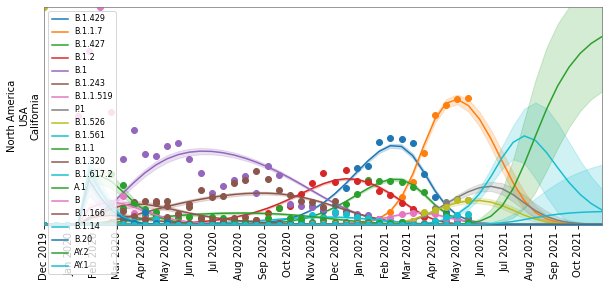

In [38]:
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ca_top_strains,
    queries=['North America / USA / California'],
    filename="paper/per_region_forecasts/california.png"
)

## North America / USA / New York

In [39]:
ny_top_strains = find_prevalent_strains(latest_fit, 'North America / USA / New York')

   137273 Generating output tensor
   137274 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


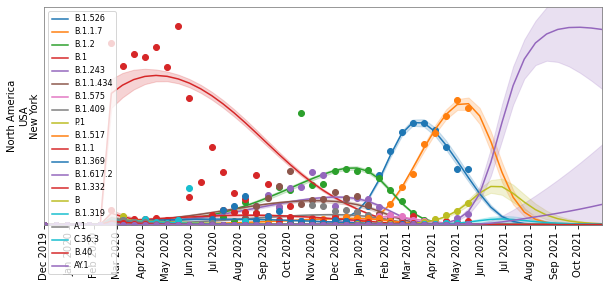

In [40]:
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries='North America / USA / New York',
    filename="paper/per_region_forecasts/new_york.png")

## Europe / United Kingdom / England

   156678 Generating output tensor
   156679 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


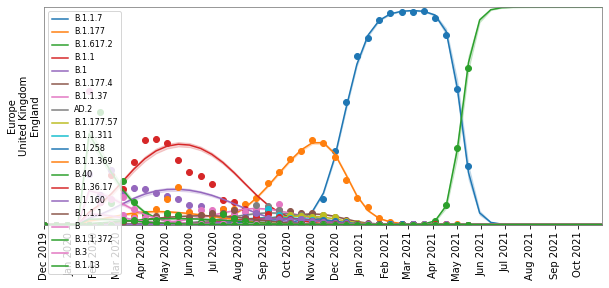

In [41]:
region = 'Europe / United Kingdom / England'
ny_top_strains = find_prevalent_strains(latest_fit, region)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/uk_england.png")

## North America / USA

   175933 Generating output tensor
   175934 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


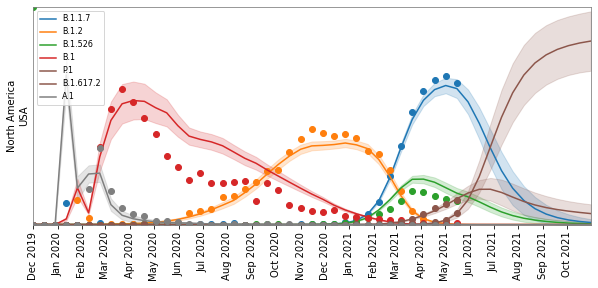

In [42]:
region = 'North America / USA'
ny_top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=ny_top_strains,
    queries=region,
    filename="paper/per_region_forecasts/USA.png")

## Europe, Africa and Asia Plot preparation

In [43]:
top_strains_europe =find_prevalent_strains(latest_fit, 'Europe',n=5)
top_strains_africa = find_prevalent_strains(latest_fit, 'Africa',n=5)
top_strains_asia = find_prevalent_strains(latest_fit, 'Asia',n=5)

In [44]:
top_strains = list(set(top_strains_europe + top_strains_africa + top_strains_asia))

In [45]:
len(top_strains)

9

# Europe

   184617 Generating output tensor
   184618 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


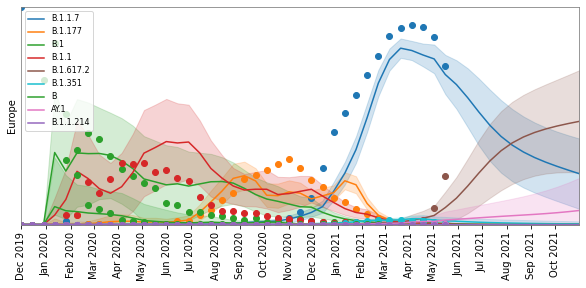

In [46]:
region = 'Europe'
#top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
filename="paper/per_region_forecasts/europe.png")

# Asia

   192597 Generating output tensor
   192598 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


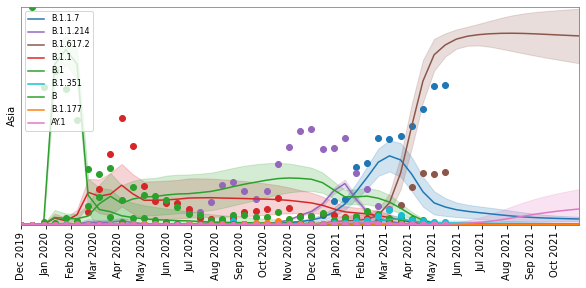

In [47]:
region = 'Asia'
#top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/asia.png",
    colors=z['colors'])

# Africa

   201378 Generating output tensor
   201379 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


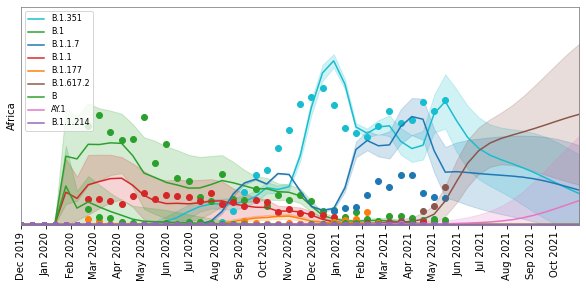

In [48]:
region = 'Africa'
#top_strains = find_prevalent_strains(latest_fit, region,n=7)
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit,
    strains_to_show=top_strains,
    queries=region,
    filename="paper/per_region_forecasts/africa_latest.png",
    colors=z['colors'])

## Day 346:  B.1.1.7 in UK

In [49]:
plot_return.keys()

dict_keys(['colors'])

   209140 Generating output tensor
   209142 --- Processing query 0


Max days of model: 346
sel_forecast shape torch.Size([37, 1281])
sel_forecast_lb shape torch.Size([37, 1281])


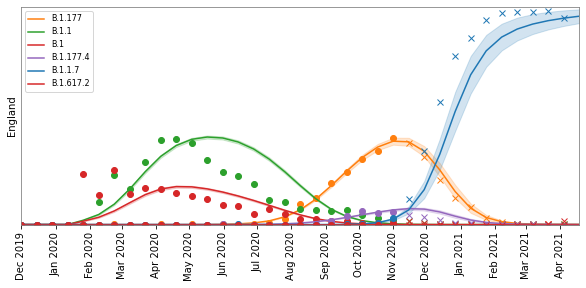

In [50]:
importlib.reload(mutrans_helpers)

i = 14
key, fit_d346 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

#strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
#                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

strains_from_manuscript_figure = ['B.1.177.4','B.1.1','B.1.177', 'B.1.617.2','B.1','B.1.1.7']


matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=fit_d346, 
    strains_to_show=strains_from_manuscript_figure,queries=['England'],
    future_fit=latest_fit,
    filename="paper/forecasts/forecast_day_346.png",
    colors=england_day_514_plot_return['colors']
)

In [51]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

fit_eval_d346 = mutrans_helpers.evaluate_fit_forecast(fit_d346, latest_fit)

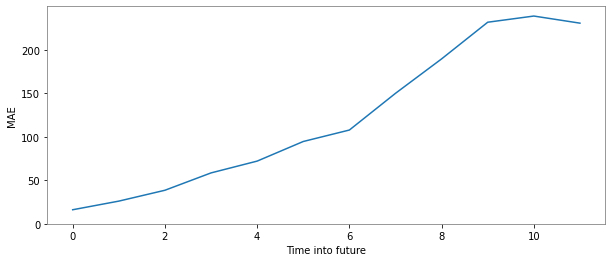

In [52]:
# Plot MAE
plt.plot(fit_eval_d346['mae'])
plt.ylim(0, None)
plt.ylabel("MAE")
plt.xlabel("Time into future");

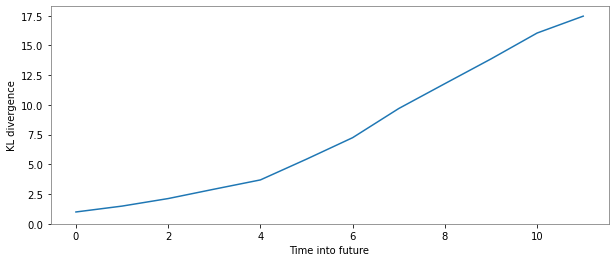

In [53]:
# Plot KL
plt.plot(fit_eval_d346['kl'])
plt.ylim(0, None)
plt.ylabel("KL divergence")
plt.xlabel("Time into future");

In [54]:
# Entropy
if False:
    plt.plot(-fit_eval_d346['log_likelihood'], "r-");
    plt.plot(fit_eval_d346['entropy'], "k--");
    plt.plot(fit_eval_d346['kl'], "g--");

In [55]:
if False:
    plt.plot(fit_eval_d346['log_likelihood'].exp(), "r-");
    plt.plot((-fit_eval_d346['entropy']).exp(), "k--");

In [56]:
def get_prediction_match(fit, query, future_fit, periods_into_future=4):
    forecast = mutrans_helpers.generate_forecast(fit=fit, queries=[query],future_fit=future_fit)
    forecast_values = mutrans_helpers.get_forecast_values(forecast=forecast)

    lineage_id_inv = forecast_values["lineage_id_inv"]

    last_observed_period = forecast_values['observed'].shape[1] - 1
    last_available_period = forecast_values['predicted'].shape[2]

    match_count = 0
    total_count = 0
    
    
    for i in range(last_observed_period, last_observed_period+periods_into_future):
        predicted_strain = lineage_id_inv[np.argmax(forecast_values['predicted'][0,0,i,:])]
        actual_strain = lineage_id_inv[np.argmax(forecast_values['observed_future'][0,i,:])]
        total_count += 1
        if predicted_strain == actual_strain:
            match_count += 1
        
    return {
        'match_count': match_count,
        'total_count': total_count,
    }

In [57]:
def get_frac_pred_match_for_region(region, first_model_index = 1):
    keys = fits.keys()
    frac_match_vals = []
    for j in range(first_model_index, len(keys)-12):
        key, fit_eval = mutrans_helpers.get_fit_by_index(fits, j)
        pred_match = get_prediction_match(fit_eval, region, latest_fit)
        frac_match = pred_match['match_count'] / pred_match['total_count']
        frac_match_vals.append(frac_match)
    return np.mean(frac_match_vals)

In [58]:
logging.getLogger().setLevel(logging.ERROR)

In [59]:
get_frac_pred_match_for_region('USA')

0.796875

In [60]:
get_frac_pred_match_for_region('Europe')

0.609375

In [61]:
get_frac_pred_match_for_region('England')

0.625

In [62]:
get_frac_pred_match_for_region('Asia')

0.109375

In [63]:
get_frac_pred_match_for_region('Africa')

0.015625

In [64]:
get_frac_pred_match_for_region('Brazil')

0.59375

In [65]:
get_frac_pred_match_for_region('USA / California')

0.40625